In [1]:
## Notebook env: old_cell2loc_env (old_cell2loc_env kernel)
## this notebook performs cell2location to *spatially* deconvolute cells using a reference annotated scRNAseq dataset

In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

In [3]:
sc_data_folder = '/home/ssobti/projects/farnaz_spatial/data/mouse_data/combined_and_independent_refs/'
results_folder = '/home/ssobti/projects/farnaz_spatial/output_data/monkey/cell2location/old_cell2location_multi_ref_annot/'

In [4]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "combined_refs_raw_data_seurat.h5ad")

In [5]:
np.unique(adata_snrna_raw.obs['dataset'])

array(['cohen-cold-dorso', 'cohen-cold-ing', 'cohen-rt-dorso',
       'cohen-rt-ing', 'mBAT', 'nuclear_ingWAT'], dtype=object)

In [6]:
adata_snrna_raw.obs['cell_type_final'][adata_snrna_raw.obs['cell_type_final'] == 'Vascular_smooth muscle'] = 'Vascular_smooth_muscle'

In [7]:
datasets_to_keep = np.array(adata_snrna_raw.obs['dataset'] == 'mBAT') | np.array(adata_snrna_raw.obs['dataset'] == 'nuclear_ingWAT')

In [8]:
adata_snrna_raw = adata_snrna_raw[datasets_to_keep,]

In [9]:
adata_snrna_raw.obs

,orig.ident,nCount_RNA,nFeature_RNA,dataset,sample_name,cell_type_final,percent.mt
AAACCCAAGCAAGGAA_1,0,7437.0,1839,mBAT,4,Macrophages,0.0
AAACCCAAGCCTGCCA_1,0,2444.0,907,mBAT,4,B_cells,0.0
AAACCCAAGGGCCAAT_1,0,4746.0,1808,mBAT,4,T_cells,0.0
AAACCCACAATACAGA_1,0,7588.0,2141,mBAT,4,Macrophages,0.0
AAACCCACACAACGTT_1,0,8909.0,2605,mBAT,4,Macrophages,0.0
...,...,...,...,...,...,...,...
Mm_ING_11-1_GGTGAAGCAATACCCA,0,665.0,514,nuclear_ingWAT,42,Adipocyte_progenitors,0.0
Mm_ING_11-1_CCCGAAGAGGTGGCTA,0,600.0,479,nuclear_ingWAT,42,Adipocyte_progenitors,0.0
Mm_ING_11-1_ACTGATGAGTTCCAGT,0,545.0,409,nuclear_ingWAT,42,Adipocyte_progenitors,0.0
Mm_ING_11-1_GATAGAAAGAGTCCGA,0,475.0,346,nuclear_ingWAT,42,Adipocyte_progenitors,0.0


In [10]:
adata_snrna_raw.var

,_index,features
0,Xkr4,Xkr4
1,Sox17,Sox17
2,Mrpl15,Mrpl15
3,Lypla1,Lypla1
4,Gm37988,Gm37988
...,...,...
16603,Itih3,Itih3
16604,Defb30,Defb30
16605,Mfrp,Mfrp
16606,Gm29292,Gm29292


In [11]:
adata_snrna_raw.var.set_index('_index', drop=True, inplace=True)
adata_snrna_raw.var.index.name = None

In [12]:
adata_snrna_raw.var

,features
Xkr4,Xkr4
Sox17,Sox17
Mrpl15,Mrpl15
Lypla1,Lypla1
Gm37988,Gm37988
...,...
Itih3,Itih3
Defb30,Defb30
Mfrp,Mfrp
Gm29292,Gm29292


In [13]:
adata_snrna_raw.var['SYMBOL'] = adata_snrna_raw.var.index

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
#del adata_snrna_raw.raw

In [14]:
## Cell type annotations and batch key
adata_snrna_raw.obs['annotation_1'] = adata_snrna_raw.obs['cell_type_final']
adata_snrna_raw.obs['sample'] = adata_snrna_raw.obs['dataset']

## 1. Reduce the number of genes by discarding lowly expressed genes

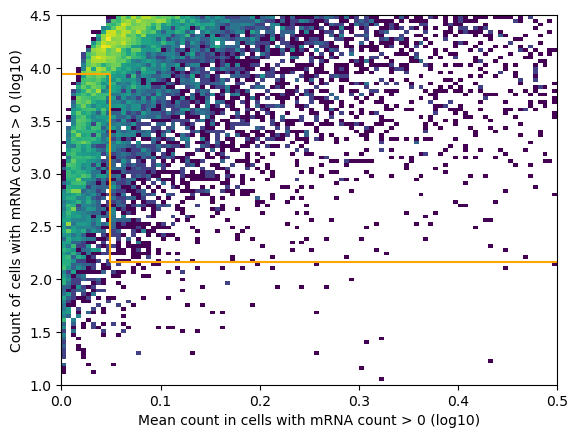

In [15]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']

plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean']),
           np.log10(adata_snrna_raw.var['n_cells']), bins=100,
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.xlabel('Mean count in cells with mRNA count > 0 (log10)');
plt.ylabel('Count of cells with mRNA count > 0 (log10)');

In [16]:
# Show the number of selected cells and genes:
adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)].shape

(291834, 13082)

In [17]:
# Filter the object:
# select genes based on mean expression in non-zero cells
adata_snrna_raw = adata_snrna_raw[:,(np.array(np.log10(adata_snrna_raw.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(adata_snrna_raw.var['n_cells']) > cell_count_cutoff)
              & np.array(~adata_snrna_raw.var['SYMBOL'].isna())]

In [18]:
# Add counts matrix as adata.raw
adata_snrna_raw.raw = adata_snrna_raw

## 2. Show UMAP of cells

In [19]:
#########################
adata_snrna_raw.X = adata_snrna_raw.raw.X.copy()
sc.pp.log1p(adata_snrna_raw)

sc.pp.scale(adata_snrna_raw, max_value=10)
sc.tl.pca(adata_snrna_raw, svd_solver='arpack', n_comps=80, use_highly_variable=False)

# Plot total counts over PC to check whether PC is indeed associated with total counts
#sc.pl.pca_variance_ratio(adata_snrna_raw, log=True)
#sc.pl.pca(adata_snrna_raw, color=['total_counts'],
#          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
#          color_map = 'RdPu', ncols = 3, legend_loc='on data',
#          legend_fontsize=10, gene_symbols='SYMBOL')

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw.obsm['X_pca'] = adata_snrna_raw.obsm['X_pca'][:, 1:]
adata_snrna_raw.varm['PCs'] = adata_snrna_raw.varm['PCs'][:, 1:]
#########################

# Here BBKNN (https://github.com/Teichlab/bbknn) is used to align batches (10X experiments)
import bbknn
bbknn.bbknn(adata_snrna_raw, neighbors_within_batch = 3, batch_key = 'sample', n_pcs = 79)
sc.tl.umap(adata_snrna_raw, min_dist = 0.8, spread = 1.5)

#########################

adata_snrna_raw = adata_snrna_raw[adata_snrna_raw.obs['annotation_1'].argsort(),:]

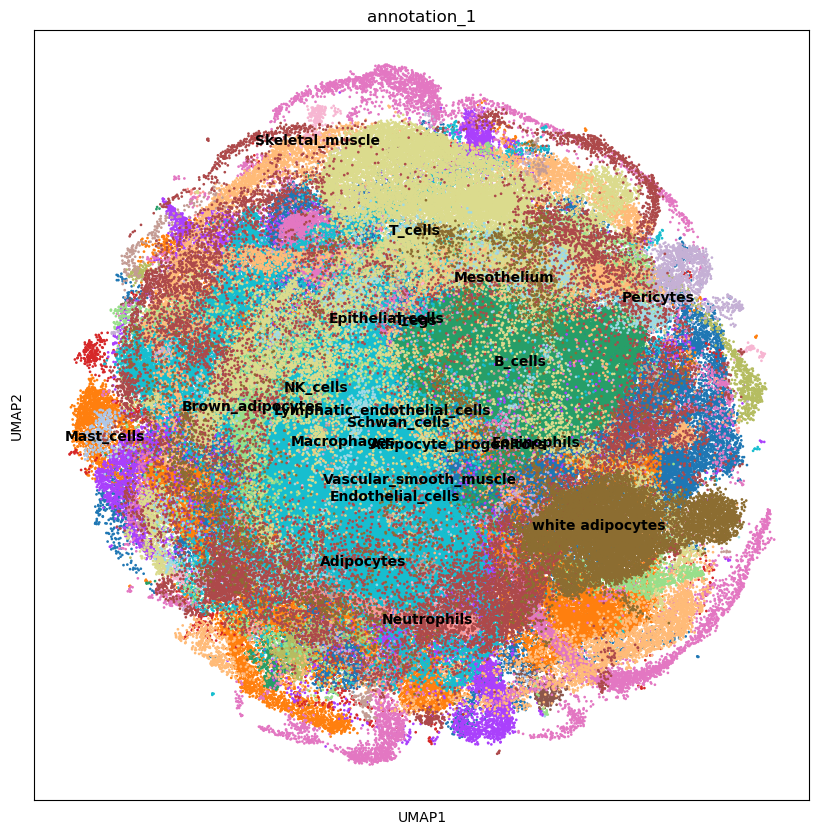

In [20]:
with mpl.rc_context({'figure.figsize': [10, 10],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw, color=['annotation_1'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)

## 3. Estimating expression signatures

In [21]:
help(cell2location.models.RegressionGeneBackgroundCoverageTorch)

Help on class RegressionGeneBackgroundCoverageTorch in module cell2location.models.RegressionGeneBackgroundCoverageTorch:

class RegressionGeneBackgroundCoverageTorch(cell2location.models.regression_torch_model.RegressionTorchModel)
 |  RegressionGeneBackgroundCoverageTorch(sample_id, cell2covar: pandas.core.frame.DataFrame, X_data: numpy.ndarray, data_type='float32', n_iter=50000, learning_rate=0.005, total_grad_norm_constraint=200, verbose=True, var_names=None, var_names_read=None, obs_names=None, fact_names=None, minibatch_size=None, minibatch_seed=[41, 56, 345], prior_eps=1e-08, nb_param_conversion_eps=1e-08, use_cuda=False, use_average_as_initial_value=True, stratify_cv=None)
 |  
 |  Negative binomial regression model that accounts for multiplicative sample scaling
 |  and additive sample background (MLE/MAP in pytorch).
 |  
 |  Parameters
 |  ----------
 |  sample_id :
 |      str with column name in cell2covar that denotes sample
 |  cell2covar :
 |      pd.DataFrame with cova

### Creating model ### - time 3.74 min
### Analysis name: RegressionGeneBackgroundCoverageTorch_22covariates_291834cells_13082genes
### Training model to determine n_epochs with CV ###


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

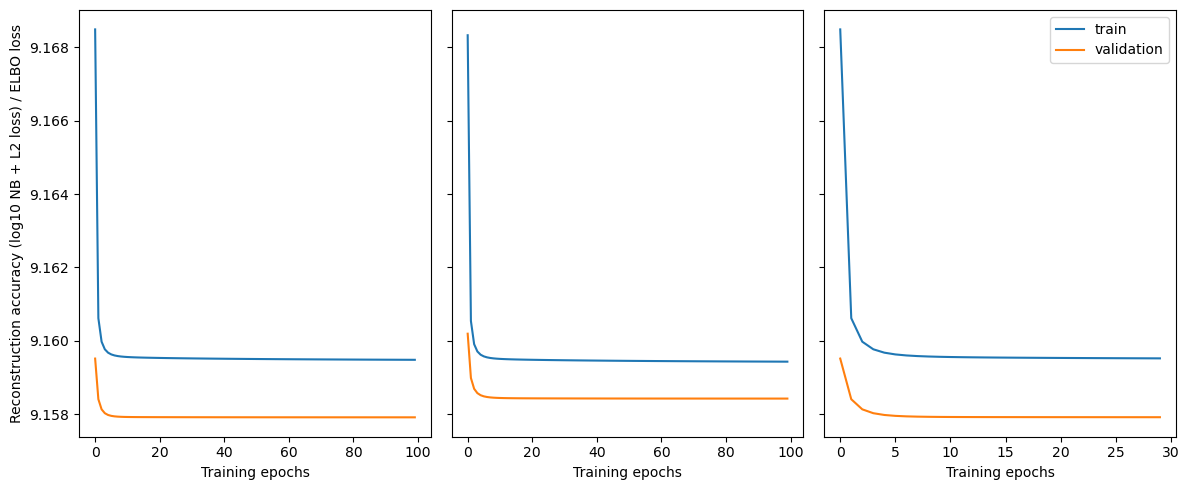

### Re-training model to stop before overfitting ###


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

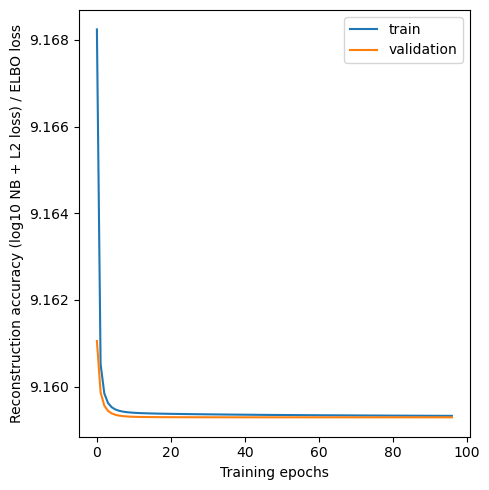

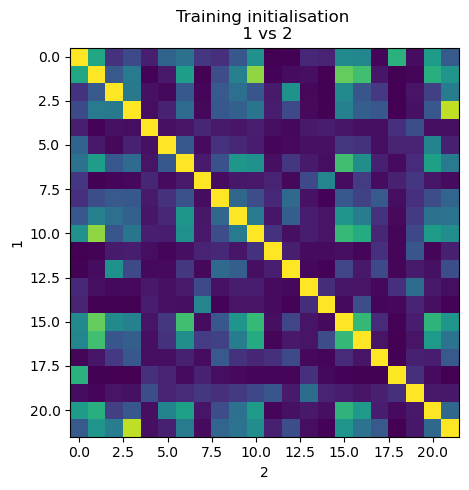

### Evaluating parameters / sampling posterior ### - time 425.1 min


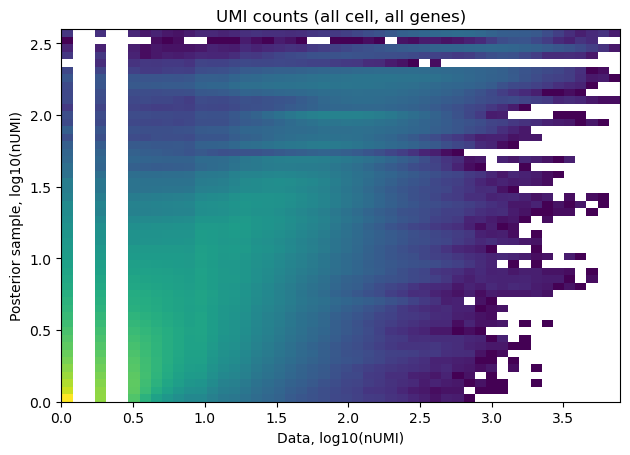

### Saving results ###
### Plotting results ###
Some error in plotting inferred sample_scaling
 Wrong number of dimensions. values.ndim > ndim [2 > 1]


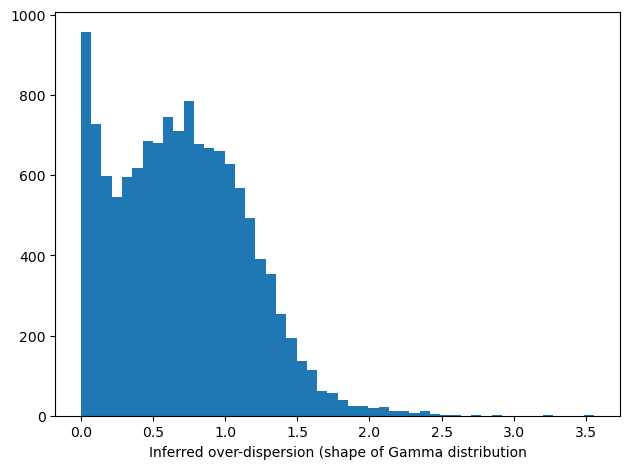

### Done ### - time 464.77 min


In [22]:
## Training the model
# Run the pipeline:
from cell2location import run_regression
r, adata_snrna_raw = run_regression(adata_snrna_raw, # input data object]

                   verbose=True, return_all=True,

                   train_args={
                    'covariate_col_names': ['annotation_1'], # column listing cell type annotation
                    'sample_name_col': 'sample', # column listing sample ID for each cell

                    # column listing technology, e.g. 3' vs 5',
                    # when integrating multiple single cell technologies corresponding
                    # model is automatically selected
                    'tech_name_col': None,

                    'stratify_cv': 'annotation_1', # stratify cross-validation by cell type annotation

                    'n_epochs': 100, 'minibatch_size': 1024, 'learning_rate': 0.01,

                    'use_cuda': False, # use GPU?

                    'train_proportion': 0.9, # proportion of cells in the training set (for cross-validation)
                    'l2_weight': True,  # uses defaults for the model

                    'readable_var_name_col': 'SYMBOL', 'use_raw': True},

                   model_kwargs={}, # keep defaults
                   posterior_args={}, # keep defaults

                   export_args={'path': results_folder + 'regression_model/', # where to save results
                                'save_model': True, # save pytorch model?
                                'run_name_suffix': ''})

reg_mod = r['mod']

In [23]:
# Export cell type expression signatures:
covariate_col_names = 'annotation_1'

inf_aver = adata_snrna_raw.raw.var.copy()
inf_aver = inf_aver.loc[:, [f'means_cov_effect_{covariate_col_names}_{i}' for i in adata_snrna_raw.obs[covariate_col_names].unique()]]
from re import sub
inf_aver.columns = [sub(f'means_cov_effect_{covariate_col_names}_{i}', '', i) for i in adata_snrna_raw.obs[covariate_col_names].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

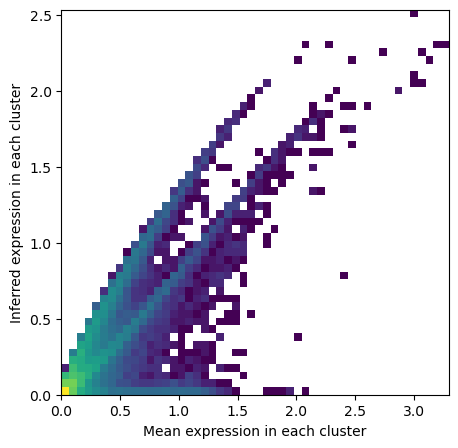

In [24]:
# Compare estimated signatures (y-axis) to analytically computed mean expression (x-axis):
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, covariate_col_names)
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

# compare estimated signatures (y-axis) to analytically computed mean expression (x-axis)
with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
               bins=50, norm=mpl.colors.LogNorm());
    plt.xlabel('Mean expression in each cluster');
    plt.ylabel('Inferred expression in each cluster');

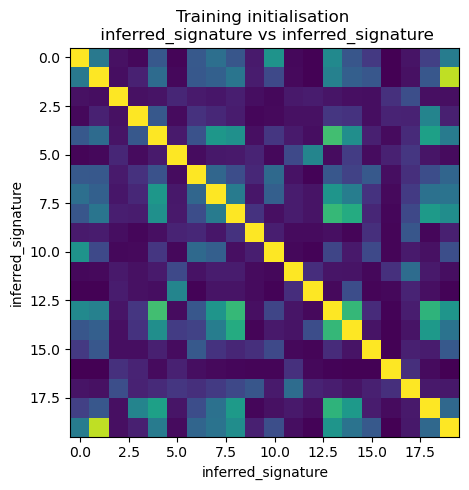

In [25]:
# Evaluate whether estimated signatures are less correlated because the confounding sample background is now removed:
# Look at how correlated are the signatures obtained by computing mean expression
with mpl.rc_context({'figure.figsize': [5, 5]}):
    reg_mod.align_plot_stability(aver, aver, 'cluster_average', 'cluster_average', align=False)

# Look at how correlated are the signatures inferred by regression model - they should be less correlated than above
with mpl.rc_context({'figure.figsize': [5, 5]}):
    reg_mod.align_plot_stability(inf_aver, inf_aver, 'inferred_signature', 'inferred_signature', align=False)

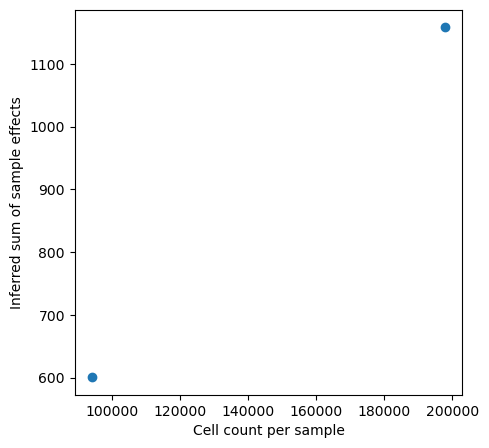

In [26]:
# Compare cell count per experiment to estimated background (soup, free-floating RNA):
# Examine how many mRNA per cell on average are background
sample_name_col = 'sample'
cell_count = adata_snrna_raw.obs[sample_name_col].value_counts()
cell_count.index = [f'means_sample_effect{sample_name_col}_{i}' for i in cell_count.index]
soup_amount = reg_mod.sample_effects.sum(0)

with mpl.rc_context({'figure.figsize': [5, 5]}):
    plt.scatter(cell_count[soup_amount.index].values.flatten(),
                soup_amount.values.flatten());
    plt.xlabel('Cell count per sample'); # fraction of reads in cells
    plt.ylabel('Inferred sum of sample effects');

## 4. Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow

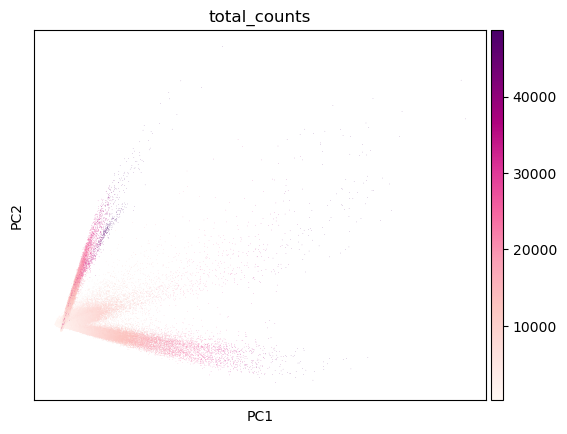

In [27]:
adata_snrna_raw_cor = adata_snrna_raw.copy()
del adata_snrna_raw_cor.uns['log1p']

adata_snrna_raw_cor.X = np.array(reg_mod.normalise(adata_snrna_raw_cor.raw.X.copy()))

sc.pp.log1p(adata_snrna_raw_cor)
sc.pp.scale(adata_snrna_raw_cor, max_value=10)
# when all RNA of a given gene are additive background this results in NaN after scaling
adata_snrna_raw_cor.X[np.isnan(adata_snrna_raw_cor.X)] = 0
sc.tl.pca(adata_snrna_raw_cor, svd_solver='arpack', n_comps=80, use_highly_variable=False)

adata_snrna_raw.obs['total_counts'] = np.array(adata_snrna_raw.raw.X.sum(1)).flatten()
adata_snrna_raw_cor.obs['total_counts'] = adata_snrna_raw.obs['total_counts'].values.copy()

sc.pl.pca(adata_snrna_raw_cor, color=['total_counts'],
          components=['1,2'],
          color_map = 'RdPu', ncols = 2, legend_loc='on data', vmax='p99.9',
          legend_fontsize=10)

# remove the first PC which explains large amount of variance in total UMI count (likely technical variation)
adata_snrna_raw_cor.obsm['X_pca'] = adata_snrna_raw_cor.obsm['X_pca'][:, 1:]
adata_snrna_raw_cor.varm['PCs'] = adata_snrna_raw_cor.varm['PCs'][:, 1:]

# here we use standard neighbors function rather than bbknn
# to show that the regression model can merge batches / experiments
sc.pp.neighbors(adata_snrna_raw_cor, n_neighbors = 15, n_pcs = 79, metric='cosine')
sc.tl.umap(adata_snrna_raw_cor, min_dist = 0.8, spread = 1)

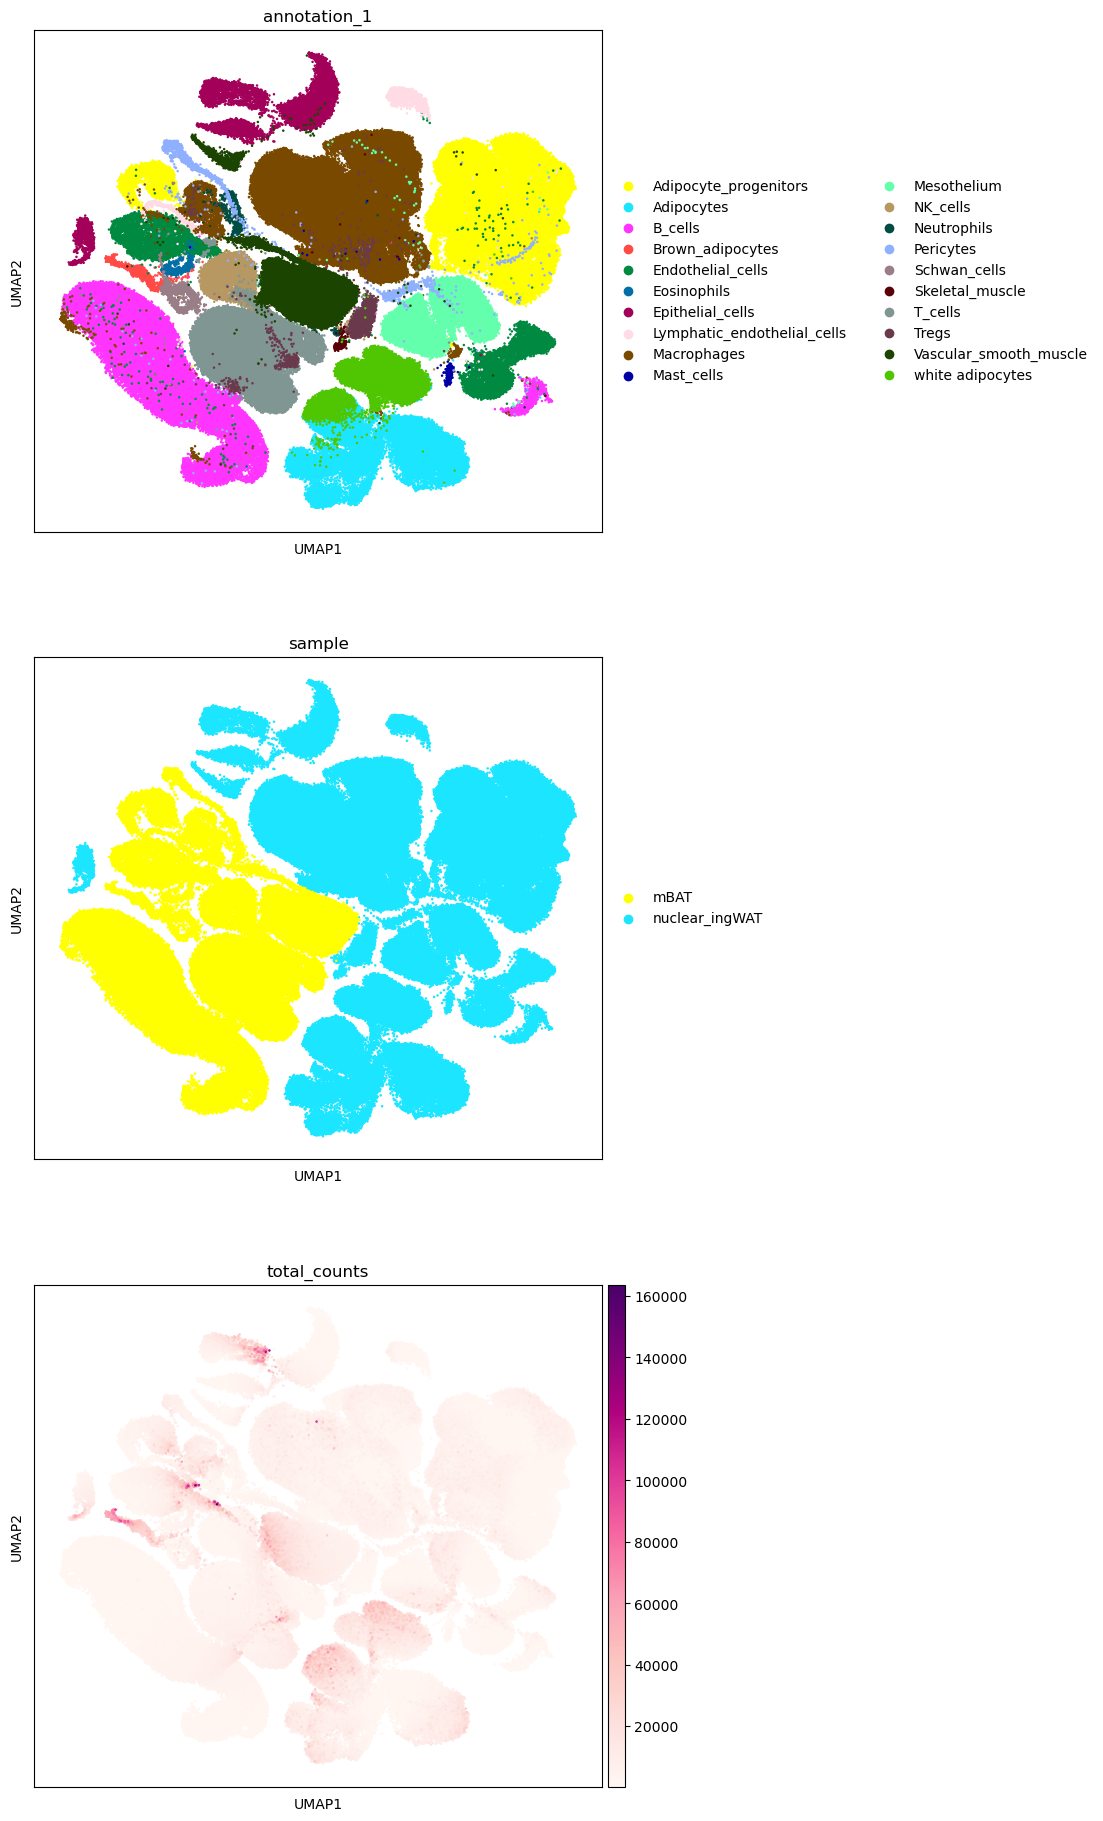

In [28]:
with mpl.rc_context({'figure.figsize': [7, 7],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata_snrna_raw_cor, color=['annotation_1', 'sample', 'total_counts'],
               color_map = 'RdPu', ncols = 1, size=13, #legend_loc='on data',
               legend_fontsize=10, palette=sc.pl.palettes.default_102)